# SegCNN: Rethinking CNN for Skin Lesion Segmentation

Welcome to the official tutorial for SegCNN, a comprehensive guide to skin lesion segmentation. 

## Overview

SegCNN provides an efficient and effective way to segment skin lesions using convolutional neural networks (CNN). With this tutorial, you will learn how to train and test the model with a single command.


Please make sure that the versions of TensorFlow and Keras are 2.12.0, and the version of KerasCV is 0.5.0.

In [42]:
!pip install tensorflow
!pip install keras_cv

import tensorflow as tf

# Check TensorFlow and Keras version
tensorflow_version = tf.__version__
keras_version = tf.keras.__version__

print(f"TensorFlow Version: {tensorflow_version}")
print(f"Keras Version: {keras_version}")

TensorFlow Version: 2.17.1
Keras Version: 3.5.0


In [43]:
tensorflow_version = tf.__version__
keras_version = tf.keras.__version__

print(f"TensorFlow Version: {tensorflow_version}")
print(f"Keras Version: {keras_version}")

TensorFlow Version: 2.17.1
Keras Version: 3.5.0


In [44]:
# 检查 CUDA 版本（需要安装 nvidia-pyindex）
!nvcc --version

# 检查 GPU 是否被 TensorFlow 识别
import tensorflow as tf
print("TensorFlow 版本:", tf.__version__)
print("GPU 可用:", tf.config.list_physical_devices('GPU'))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
TensorFlow 版本: 2.17.1
GPU 可用: []


 # Importing Necessary Dependencies

In [45]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow import keras

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.densenet import DenseNet201, DenseNet121, DenseNet169
from keras.utils import plot_model

import cv2
import skimage.io as io
import skimage.transform as trans
from sklearn.metrics import confusion_matrix, roc_curve, auc
from skimage.measure import label, regionprops
from keras.initializers import Constant
from keras_cv.layers import *

from scipy.ndimage.morphology import distance_transform_edt as edt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix

<ipython-input-45-1435e53129ee>:30: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import distance_transform_edt as edt


In [46]:
#You only need to set up the model and whether to train it.
model = "SegCNN" # or UNet
train = False    # or True  

In [47]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Importing Data

If you are using your own dataset, you can import it and then change the data path accordingly. Below is an example demonstrating how to import the ISIC2018 dataset. Here we use the ISIC 2018 dataset, which has already been uploaded by others on the Kaggle platform, or it can also be downloaded from https://challenge.isic-archive.com/data/#2018."

In [48]:
#ISIC 2018
images_train = sorted( glob.glob("/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/*.jpg"), key=numericalSort)
mask_train =  sorted(glob.glob("/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/*_segmentation.png"), key=numericalSort)
images_valid = sorted( glob.glob("/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input/*.jpg"), key=numericalSort)
mask_valid =  sorted(glob.glob("/kaggle/input/gfdgffd/ISIC2018_Task1_Validation_GroundTruth (1)/ISIC2018_Task1_Validation_GroundTruth/*_segmentation.png"), key=numericalSort)
images_test = sorted( glob.glob("/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input/*.jpg"), key=numericalSort)
mask_test =  sorted(glob.glob("/kaggle/input/gfdgffd/ISIC2018_Task1_Test_GroundTruth (1)/ISIC2018_Task1_Test_GroundTruth/*_segmentation.png"), key=numericalSort)

In [49]:
data_train = pd.DataFrame({'images':images_train,'masks':mask_train})
data_train.head(9)

,images,masks
0,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
1,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
2,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
3,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
4,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
5,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
6,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
7,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...
8,/kaggle/input/isic2018-challenge-task1-data-se...,/kaggle/input/isic2018-challenge-task1-data-se...


In [50]:
data_val = pd.DataFrame({'images':images_valid,'masks':mask_valid})

In [51]:
data_test = pd.DataFrame({'images':images_test,'masks':mask_test})

In [52]:
target_size=(256,256)
batch_size = 8

# Data Augmentation

In [53]:
def custom_preprocessing(x):
    x = x * np.random.uniform(0.7, 1.3)
    return x
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range=(0.9, 1.1),
                            channel_shift_range=(0.05),
                            vertical_flip=True,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            preprocessing_function=custom_preprocessing,
                            rescale=1./255.)

In [54]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=target_size, 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=batch_size,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=target_size, 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=batch_size,
                                    class_mode=None
)

Found 2594 validated image filenames.
Found 2594 validated image filenames.


In [55]:
valdatagen = ImageDataGenerator(rescale=1./255.)

In [56]:
image_validation=valdatagen.flow_from_dataframe(data_val,  
                                    target_size=target_size, 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=batch_size,
                                    class_mode=None
)

mask_validation=valdatagen.flow_from_dataframe(data_val, 
                                    target_size=target_size, 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=batch_size,
                                    class_mode=None
)

Found 100 validated image filenames.
Found 100 validated image filenames.


In [57]:
testdatagen = ImageDataGenerator(rescale=1./255.)

In [58]:
image_test=testdatagen.flow_from_dataframe(data_test,  
                                    target_size=target_size, 
                                    color_mode='rgb',
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=1,
                                    class_mode=None
)

mask_test=testdatagen.flow_from_dataframe(data_test, 
                                    target_size=target_size, 
                                    color_mode='grayscale',
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=1,
                                    class_mode=None
)

Found 1000 validated image filenames.
Found 1000 validated image filenames.


In [60]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)
test_gen=zip(image_test,mask_test)

# Building U-Net
Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18. Springer International Publishing, 2015.

In [61]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    conv6 = Conv2D(512, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)
    conv7 = Conv2D(256, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)
    conv8 = Conv2D(128, 3, padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)
    conv9 = Conv2D(64, 3, padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# The Structure of the Cross-scale Spatial Attention Module 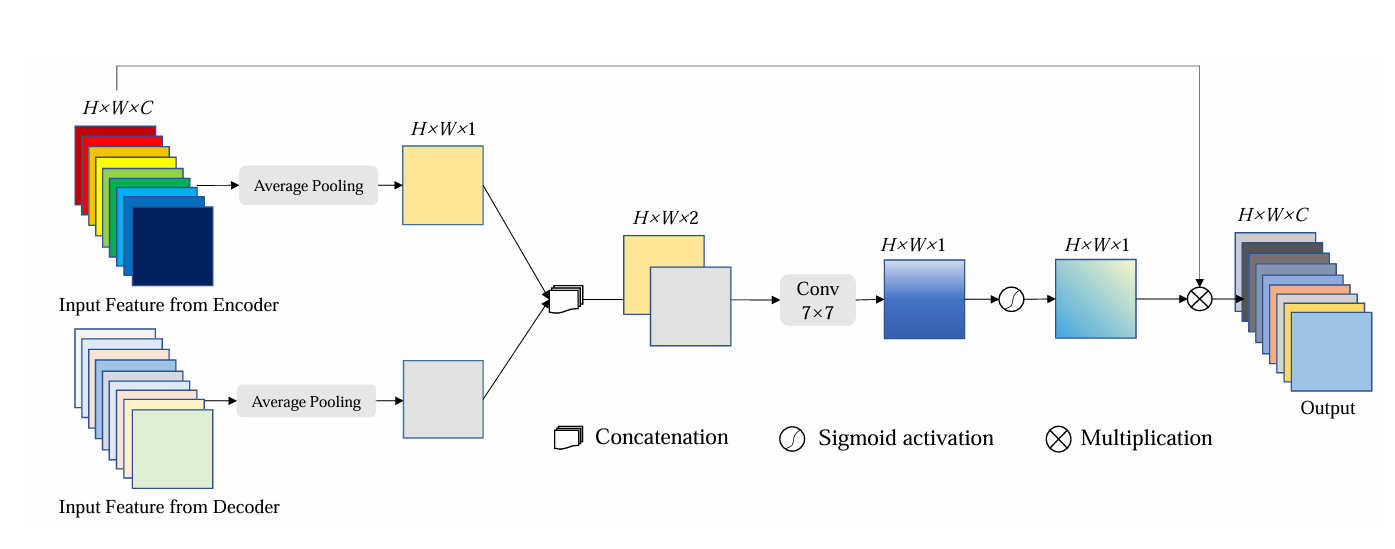

In [62]:

def CSA(concat1,concat2,kernel_size=7):

    if K.image_data_format() == "channels_first":
        channel1 = concat1.shape[1]
        sa1 = Permute((2, 3, 1))(concat1)
        channel2 = concat2.shape[1]
        sa2 = Permute((2, 3, 1))(concat2)
    else:
        channel1 = concat1.shape[-1]
        sa1 = concat1
        channel2 = concat2.shape[-1]
        sa2 = concat2
    avg_pool1 = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(sa1)
    assert avg_pool1.shape[-1] == 1
    avg_pool2 = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(sa2)
    assert avg_pool2.shape[-1] == 1

    sa = Concatenate(axis=3)([avg_pool1,avg_pool2])
    assert sa.shape[-1] == 2
    sa = Conv2D(filters=1,
                        kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(sa)
    assert sa.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        sa = Permute((3, 1, 2))(sa)

    return multiply([concat1, sa])

# Spatial Attention Module
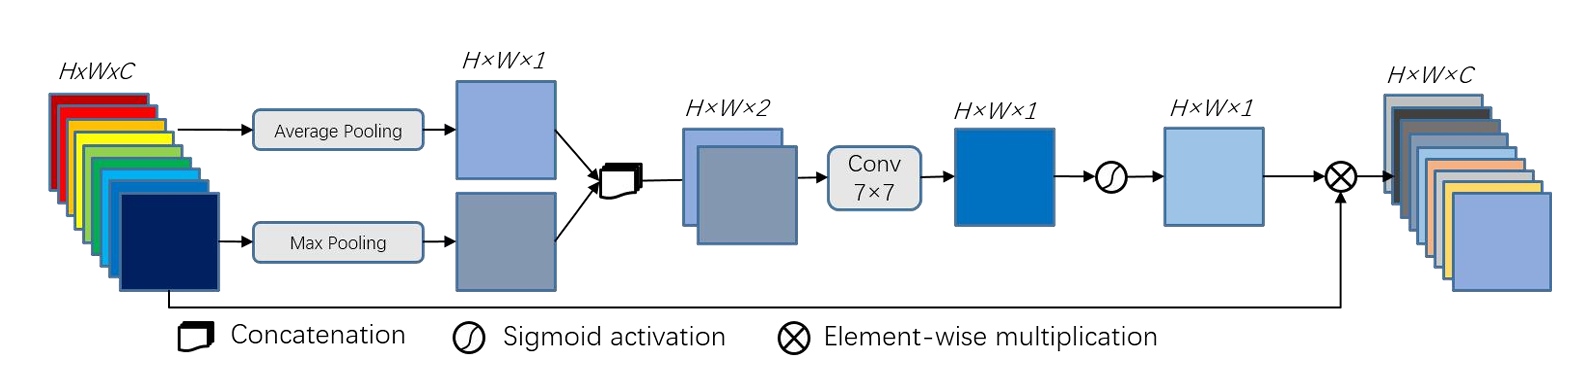
Image reference: Guo, C., Szemenyei, M., Yi, Y., Wang, W., Chen, B., & Fan, C. (2021, January). SA-UNet: Spatial Attention U-Net for Retinal Vessel Segmentation. In 2020 25th International Conference on Pattern Recognition (ICPR) (pp. 1236-1242). IEEE.

In [63]:

def SA(concat1,kernel_size=7):

    if K.image_data_format() == "channels_first":
        channel1 = concat1.shape[1]
        sa1 = Permute((2, 3, 1))(concat1)
    else:
        channel1 = concat1.shape[-1]
        sa1 = concat1

    avg_pool1 = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(sa1)
    assert avg_pool1.shape[-1] == 1
    max_pool1 = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(sa1)
    assert max_pool1.shape[-1] == 1
    sa = Concatenate(axis=3)([avg_pool1,max_pool1])
    assert sa.shape[-1] == 2
    sa = Conv2D(filters=1,
                        kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(sa)
    assert sa.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        sa = Permute((3, 1, 2))(sa)

    return multiply([concat1, sa])

 Spatial Attention Residual Ultralight Convolution (SARUC)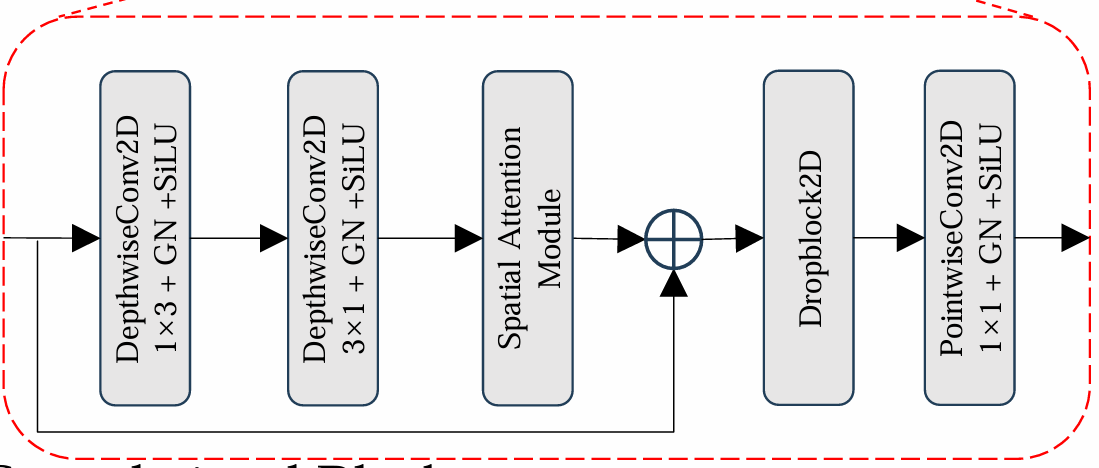

In [64]:
def SaruConv(x, channel=32, rate=0.1, k=3):
    inputs = x
    x = DepthwiseConv2D(kernel_size=(1, k),
                         depth_multiplier=1,
                         padding="same")(x)
    x = GroupNormalization(groups=8)(x)
    x = Activation("silu")(x)
    x = DepthwiseConv2D(kernel_size=(k,1),
                         depth_multiplier=1,
                         padding="same")(x)
    x = GroupNormalization(groups=8)(x)
    x = Activation("silu")(x)
    x = SA(x)
    x = x + inputs
    x = DropBlock2D(rate=rate, block_size=7)(x)
    x = Conv2D(filters=channel, kernel_size=(1, 1),
                padding="same")(x)
    x = GroupNormalization(groups=8)(x)
    x = Activation("silu")(x)

    return x

 # The  Architecture of SegCNN
 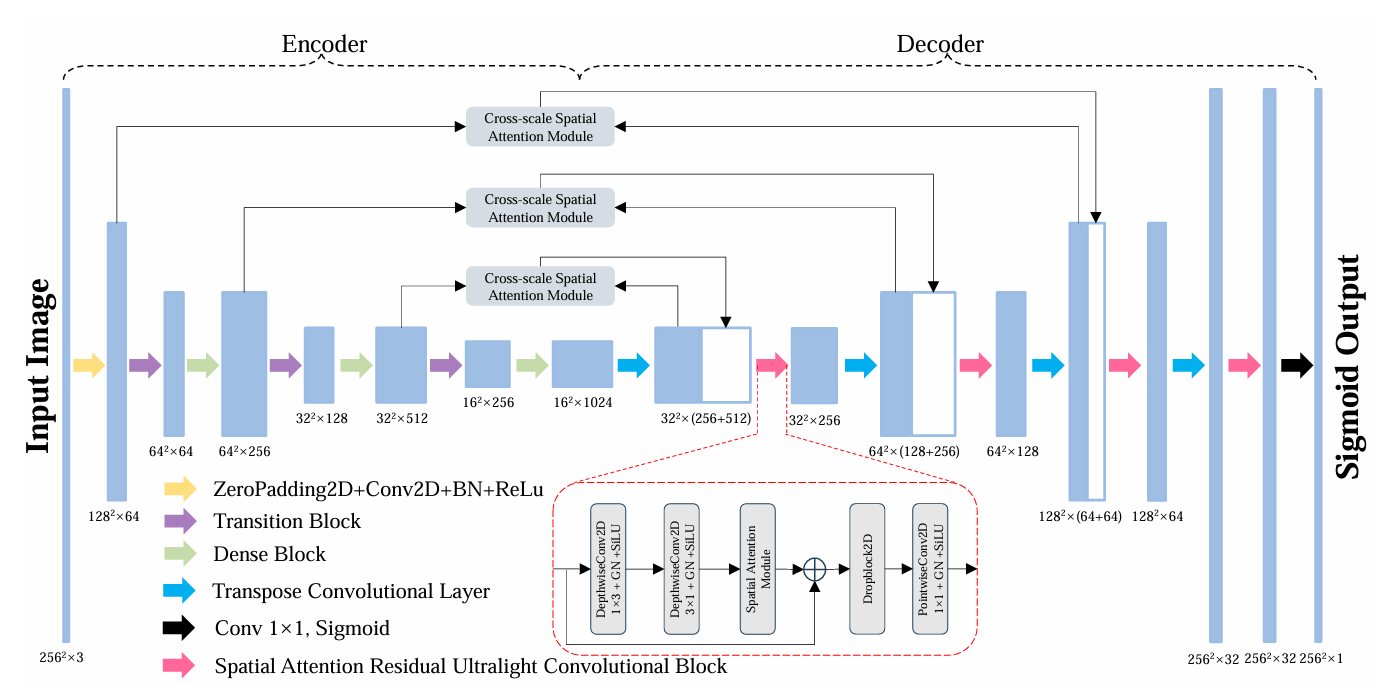

In [67]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

def SegCNN(nClasses=1, input_height=256, input_width=256, channel=32, rate=0.25):
    img_input = Input(shape=(input_height, input_width, 3))  # defining the Input shape

    Encoder = DenseNet121(weights=None, include_top=False, input_tensor=img_input)

    # Load local weights manually
    local_weights_path = '/kaggle/input/weights/keras/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
    Encoder.load_weights(local_weights_path)

    f1 = Encoder.get_layer(name="conv1_relu").output  
    f2 = Encoder.get_layer(name="conv2_block6_concat").output  
    f3 = Encoder.get_layer(name="conv3_block12_concat").output  
    f4 = Encoder.get_layer(name="conv4_block24_concat").output  

    f4_up_2 = Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding='same',
                              kernel_initializer='he_normal')(f4)

    f3 = concatenate([CSA(f3, f4_up_2, 7), f4_up_2], axis=-1) 
    f3 = SaruConv(f3, channel*8, rate=rate)
    
    f3_up2 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same',
                             kernel_initializer='he_normal')(f3)
    f2 = concatenate([CSA(f2, f3_up2, 7), f3_up2], axis=-1) 
    f2 = SaruConv(f2, channel*4, rate=rate) 

    f2_up2 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer='he_normal')(f2)
    f1 = concatenate([CSA(f1, f2_up2, 7), f2_up2], axis=-1) 
    f1 = SaruConv(f1, channel*2, rate=rate) 

    f1_up2 = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer='he_normal')(f1)
    f = SaruConv(f1_up2, channel, rate=rate) 

    Predicted_Mask = Conv2D(filters=nClasses, kernel_size=1, activation='sigmoid')(f)

    model = Model(img_input, Predicted_Mask)

    return model


# Build the model
model_name = "SegCNN"  # or "UNet"

if model_name == "SegCNN":
    model = SegCNN(nClasses=1, input_height=256, input_width=256, channel=32, rate=0.25)
elif model_name == "UNet":
    model = unet()

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_20         │ (None, 262, 262, 3)    │              0 │ input_layer_15[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_20[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_21         │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_21[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,338,511 (27.99 MB)

 Trainable params: 7,287,119 (27.80 MB)

 Non-trainable params: 51,392 (200.75 KB)

Manually download the weights and load locally

In [68]:
model_name = "SegCNN"  # or "UNet"

if model_name == "SegCNN":
    model = SegCNN(nClasses=1, input_height=256, input_width=256, channel=32, rate=0.25)
elif model_name == "UNet":
    model = unet()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_22         │ (None, 262, 262, 3)    │              0 │ input_layer_16[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_22[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_23         │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_23[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,338,511 (27.99 MB)

 Trainable params: 7,287,119 (27.80 MB)

 Non-trainable params: 51,392 (200.75 KB)

In [69]:
class FuzzyRoughLoss(keras.losses.Loss):
    def __init__(self, alpha=1, **kwargs):
        super(FuzzyRoughLoss, self).__init__(**kwargs)
        self.alpha = alpha

    def distance_field(self, img):
        field = np.zeros_like(img)
        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5
            if fg_mask.any():
                bg_mask = ~fg_mask
                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)
                field[batch] = fg_dist + bg_dist
        return 1 - np.exp(-(field**2) / self.alpha)

    def call(self, target,pred ):
        # assert pred.shape.ndims == 4 or pred.shape.ndims == 5
        # assert pred.shape == target.shape

        target_dt = tf.numpy_function(self.distance_field, [target], tf.float32)
        pred_error = tf.square(pred - target)
        distance = tf.convert_to_tensor(target_dt, dtype=pred.dtype)

        dt_field = pred_error * distance
        nonzero = tf.size(tf.where(dt_field != 0))
        loss = tf.reduce_sum(dt_field) / tf.cast(nonzero, dtype=dt_field.dtype)

        return loss


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # +1 added to avoid 0/0 division
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def Jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
def Jaccard_coef_loss(y_true, y_pred):
    return 1-Jaccard_coef(y_true, y_pred)
def weighted_loss(y_true, y_pred):
    fuzzy_loss = FuzzyRoughLoss()(y_true, y_pred)  # 使用默认参数
    jaccard_loss = Jaccard_coef_loss(y_true, y_pred)
    return jaccard_loss  + fuzzy_loss
def bcc_Jaccard_coef_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred)+(1-Jaccard_coef(y_true, y_pred)))
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

import tensorflow.keras as keras
keras.utils.get_custom_objects()['dice_coef'] = dice_coef
keras.utils.get_custom_objects()['Jaccard_coef'] = Jaccard_coef
keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss
keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss
keras.utils.get_custom_objects()['bcc_Jaccard_coef_loss'] = bcc_Jaccard_coef_loss
keras.utils.get_custom_objects()['weighted_loss'] = weighted_loss

In [70]:
# Define a learning rate schedule function
def step_decay(epoch):
    print("Learning rate:", K.get_value(model.optimizer.lr))  # Print the current learning rate
    return K.get_value(model.optimizer.lr)  # Return the current learning rate value

# Learning rate scheduler to adjust the learning rate during training
print_lrate = LearningRateScheduler(step_decay)

# Reduce learning rate on plateau: if validation loss stops improving, reduce learning rate by a factor of 0.1
lrate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
                          cooldown=0, min_lr=1e-6)

# Save the model after each epoch
model_save = ModelCheckpoint(filepath="UNet_last.keras", verbose=0)

# Save the model with the best validation loss
best_weight = ModelCheckpoint(filepath="UNet_best.keras", verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=True)

# Define early stopping: stops training if validation loss doesn't improve for 15 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=False)

# Compile the model with the Adam optimizer, weighted loss function, and custom metrics
model.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_loss,
              metrics=[dice_coef, Jaccard_coef, 'accuracy'])

# Print the model summary (optional, commented out)
# model.summary()

# Train the model if 'train' is set to True
if train == True:
    hist = model.fit(
        train_gen,  # Training data generator
        validation_data=valid_gen,  # Validation data generator
        epochs=50,  # Number of epochs to train
        validation_steps=len(data_val),  # Number of steps per epoch for validation
        steps_per_epoch=len(data_train) / 8,  # Number of steps per epoch for training
        callbacks=[lrate, print_lrate, model_save, best_weight, early_stopping]  # List of callbacks
    )


In [71]:
model.load_weights("/kaggle/input/segcnn/tensorflow2/default/1/SegCNN.h5")

In [72]:

def Performance_Metrics(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch!! y_true and y_pred must have the same shape.")

    y_true_f = (y_true).flatten()
    y_pred_f = (y_pred).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dsc = (2. * intersection ) / (np.sum(y_true_f) + np.sum(y_pred_f))
    iou = (intersection) / (np.sum(y_true_f) + np.sum(y_pred_f)-intersection)
    y_true = np.asarray(y_true).astype(np.bool_)
    y_pred = np.asarray(y_pred).astype(np.bool_)

        
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    sensitivity = (tp)/(fn+tp)
    specificity = (tn)/(tn+fp)
    balancedAccuracy = (sensitivity+specificity)/2

    
    return dsc, iou, accuracy, sensitivity, specificity, balancedAccuracy

In [73]:
dice_score_test = []
jacard_score_test = []
pre=[]
sen=[]
acc=[]
spe=[]
bacc=[]

for i in range(1000):
    pred=model.predict(image_test[i])

    Prediction = pred
    Prediction[Prediction<0.5] = 0.0
    Prediction[Prediction>=0.5] = 1.0
    Prediction=Prediction.astype('uint8')
    mask = mask_test[i].astype('uint8')
    dice_score_test.append(Performance_Metrics(mask, Prediction)[0])
    jacard_score_test.append(Performance_Metrics(mask, Prediction)[1])
    acc.append(Performance_Metrics(mask, Prediction)[2])

print("DICE:"+str(np.mean(dice_score_test)))
print("JACC:"+str(np.mean(jacard_score_test)))
print("ACC："+str(np.mean(acc)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<ipython-input-72-da6cf151beca>:20: RuntimeWarning: invalid value encountered in scalar divide
  specificity = (tn)/(tn+fp)
<ipython-input-72-da6cf151beca>:20: RuntimeWarning: invalid value encountered in scalar divide
  specificity = (tn)/(tn+fp)
<ipython-input-72-da6cf151beca>:20: RuntimeWarning: invalid value encountered in scalar divide
  specificity = (tn)/(tn+fp)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
(256, 256, 3)


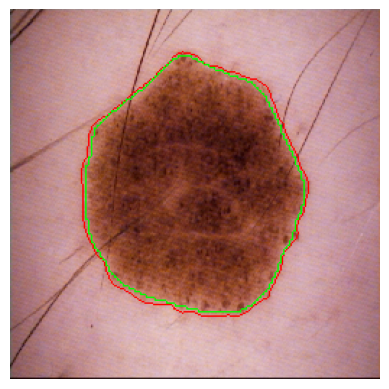

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set index of the image to visualize
i = 1

# Convert mask shape from (1, 128, 128, 1) to (128, 128)
mask = mask_test[i].astype('uint8')
mask = mask.squeeze()

# Predict segmentation mask for the selected image
pred = model.predict(image_test[i])

# Threshold prediction at 0.5 to create binary mask
pred[pred < 0.5] = 0.0
pred[pred >= 0.5] = 1.0
pred = pred.astype('uint8')
pred = pred.squeeze()

# Squeeze original image to remove extra dimensions
image = np.squeeze(image_test[i])
print(image.shape)

# Convert predictions and mask to 8-bit format (0 or 255)
pred = np.uint8(pred * 255)
mask = np.uint8(mask * 255)

# Find contours for prediction and ground truth mask
pred_contours, _ = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw prediction contours in red on a copy of the original image
image_with_pred_contour = cv2.drawContours(image.copy(), pred_contours, -1, (255, 0, 0), 1)

# Draw ground truth contours in green on the same image
image_with_mask_contour = cv2.drawContours(image_with_pred_contour, mask_contours, -1, (0, 255, 0), 1)

# Display the image with lesion boundaries
plt.imshow(image_with_mask_contour)
# plt.title('Lesion Boundaries')
plt.axis('off')
# plt.savefig('SegCNN.png', bbox_inches='tight', pad_inches=0)
plt.show()


This is segmentation